In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic, SVD, SVDpp
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy

In [3]:
from data_utils import generate_ground_truth_matrix, ground_truth_matrix_to_dataset, to_dataframe, generate_test_dataframe, naive_propensity_estimation, masked_nb_propensity_estimation, mlp_propensity_estimation
from algo import PropensitySVD

# Visualize the effect of selection bias

In [4]:
# Plot P against R (flattened)

def P_R_train(beta):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='ml-100k-v1')
    users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=beta, sample_prob=0.1)
    return P, R

beta = np.linspace(0, 2, 5)
results = [P_R_train(i) for i in beta]     

Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.
Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kw

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_84143/274249863.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


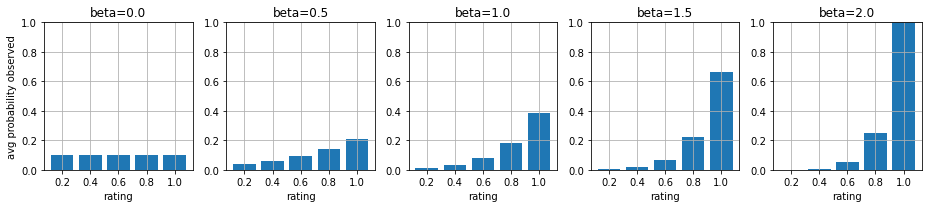

In [5]:
def average_prob(P, R):
    Ps = []
    probs = []
    for i in range(5):
        Ps.append(P.copy())
        probs.append(0)
    for i in range(5):
        Ps[i][R != (0.2 * i + 0.2)] = 0
        probs[i] = Ps[i].sum() / np.count_nonzero(Ps[i])
    return probs

fig, axs = plt.subplots(1, 5, figsize=(13, 3))
for i in range(5):
    P, R = results[i]
    probs = average_prob(P, R) 
    x_axis = ['0.2', '0.4', '0.6', '0.8', '1.0']
    axs[i].bar(x_axis, probs)
    axs[i].set(title=f'beta={round(beta[i], 2)}', xlabel='rating', ylim=(0, 1))
    axs[i].grid()
axs[0].set(ylabel='avg probability observed')
plt.tight_layout()
fig.show()
fig.savefig('./paper/figures/visualize.png', dpi=300)

# Stage 1 experiment

## ml-100k dataset


In [6]:
# beta = np.linspace(0.1, 3, 10)
# quantization = ['binary', 'onetothree', 'onetofive']
# user_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
# user_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
# user_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
# item_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
# item_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
# item_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
# svd_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
# svd_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
# svd_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}

# algo = KNNBasic(sim_options={'user_based': True}, verbose=False)

# for i in range(len(quantization)):

#     for j in range(len(beta)):
#         temp_results = []
#         truth = generate_ground_truth_matrix(
#         (1000, 1000), environment='ml-100k-v1')   

#         for iteration in range(10): 
#             users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
#                 truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
#             train_df = to_dataframe(ratings)

#             reader = Reader(rating_scale=(0, 1))
#             data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
#             trainset = data.build_full_trainset()

#             algo.fit(trainset)

#             test_df = generate_test_dataframe(R_no_noise)
#             testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
#             predictions = algo.test(testset)
#             temp_results.append(accuracy.rmse(predictions))

#         temp_results = np.array(temp_results)
#         temp_results.sort()
#         user_knn_result_avg[quantization[i]].append(temp_results.mean())
#         user_knn_result_1q[quantization[i]].append(temp_results[2])
#         user_knn_result_3q[quantization[i]].append(temp_results[7])

# algo = KNNBasic(sim_options={'user_based': False}, verbose=False)

# for i in range(len(quantization)):

#     for j in range(len(beta)):
#         temp_results = []
#         truth = generate_ground_truth_matrix(
#             (1000, 1000), environment='ml-100k-v1')

#         for iteration in range(10):
#             users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
#                 truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
#             train_df = to_dataframe(ratings)

#             reader = Reader(rating_scale=(0, 1))
#             data = Dataset.load_from_df(
#                 train_df[['userID', 'itemID', 'rating']], reader)
#             trainset = data.build_full_trainset()

#             algo.fit(trainset)

#             test_df = generate_test_dataframe(R_no_noise)
#             testset = Dataset.load_from_df(
#                 test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
#             predictions = algo.test(testset)
#             temp_results.append(accuracy.rmse(predictions))

#         temp_results = np.array(temp_results)
#         temp_results.sort()
#         item_knn_result_avg[quantization[i]].append(temp_results.mean())
#         item_knn_result_1q[quantization[i]].append(temp_results[2])
#         item_knn_result_3q[quantization[i]].append(temp_results[7])

# algo = SVD(verbose=False)  

# for i in range(len(quantization)):

#     for j in range(len(beta)):
#         temp_results = []
#         truth = generate_ground_truth_matrix(
#             (1000, 1000), environment='ml-100k-v1')

#         for iteration in range(10):
#             users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
#                 truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
#             train_df = to_dataframe(ratings)

#             reader = Reader(rating_scale=(0, 1))
#             data = Dataset.load_from_df(
#                 train_df[['userID', 'itemID', 'rating']], reader)
#             trainset = data.build_full_trainset()

#             algo.fit(trainset)

#             test_df = generate_test_dataframe(R_no_noise)
#             testset = Dataset.load_from_df(
#                 test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
#             predictions = algo.test(testset)
#             temp_results.append(accuracy.rmse(predictions))

#         temp_results = np.array(temp_results)
#         temp_results.sort()
#         svd_result_avg[quantization[i]].append(temp_results.mean())
#         svd_result_1q[quantization[i]].append(temp_results[2])
#         svd_result_3q[quantization[i]].append(temp_results[7])

In [7]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 4))
# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[0].plot(beta, user_knn_result_avg['binary'], label='2-quantization')
# axs[0].plot(beta, user_knn_result_avg['onetothree'], label='3-quantization')
# axs[0].plot(beta, user_knn_result_avg['onetofive'], label='5-quantization')
# axs[0].set(xlabel='beta', ylabel='RMSE')
# axs[0].legend(loc='upper left')

# axs[1].plot(beta, item_knn_result_avg['binary'], label='2-quantization')
# axs[1].plot(beta, item_knn_result_avg['onetothree'], label='3-quantization')
# axs[1].plot(beta, item_knn_result_avg['onetofive'], label='5-quantization')
# axs[1].set(xlabel='beta', ylabel='RMSE')
# axs[1].legend(loc='upper left')

# axs[2].plot(beta, svd_result_avg['binary'], label='2-quantization')
# axs[2].plot(beta, svd_result_avg['onetothree'], label='3-quantization')
# axs[2].plot(beta, svd_result_avg['onetofive'], label='5-quantization')
# axs[2].set(xlabel='beta', ylabel='RMSE')
# axs[2].legend(loc='upper left')
# fig.show()
# plt.tight_layout()
# fig.savefig('./paper/figures/1a.png', dpi=300)

# Synthetic dataset (`latent-static-v1`)

In [8]:
beta = np.linspace(0.1, 3, 10)
quantization = ['binary', 'onetothree', 'onetofive']
user_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
user_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
user_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}

algo = KNNBasic(sim_options={'user_based': True}, verbose=False)

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
        (500, 500), environment='latent-static-v1')   

        for iteration in range(10): 
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        user_knn_result_avg[quantization[i]].append(temp_results.mean())
        user_knn_result_1q[quantization[i]].append(temp_results[2])
        user_knn_result_3q[quantization[i]].append(temp_results[7])

algo = KNNBasic(sim_options={'user_based': False}, verbose=False)

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
            (500, 500), environment='latent-static-v1')

        for iteration in range(10):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(
                train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(
                test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        item_knn_result_avg[quantization[i]].append(temp_results.mean())
        item_knn_result_1q[quantization[i]].append(temp_results[2])
        item_knn_result_3q[quantization[i]].append(temp_results[7])

algo = SVD(verbose=False)  

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
            (500, 500), environment='latent-static-v1')

        for iteration in range(10):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(
                train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(
                test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        svd_result_avg[quantization[i]].append(temp_results.mean())
        svd_result_1q[quantization[i]].append(temp_results[2])
        svd_result_3q[quantization[i]].append(temp_results[7])

RMSE: 0.2241
RMSE: 0.2280
RMSE: 0.2220
RMSE: 0.2249
RMSE: 0.2234
RMSE: 0.2275
RMSE: 0.2242
RMSE: 0.2264
RMSE: 0.2226
RMSE: 0.2267
RMSE: 0.2309
RMSE: 0.2316
RMSE: 0.2298
RMSE: 0.2316
RMSE: 0.2345
RMSE: 0.2329
RMSE: 0.2300
RMSE: 0.2326
RMSE: 0.2313
RMSE: 0.2339
RMSE: 0.2569
RMSE: 0.2571
RMSE: 0.2550
RMSE: 0.2536
RMSE: 0.2556
RMSE: 0.2584
RMSE: 0.2611
RMSE: 0.2563
RMSE: 0.2566
RMSE: 0.2516
RMSE: 0.2642
RMSE: 0.2673
RMSE: 0.2702
RMSE: 0.2733
RMSE: 0.2697
RMSE: 0.2712
RMSE: 0.2667
RMSE: 0.2710
RMSE: 0.2676
RMSE: 0.2692
RMSE: 0.2914
RMSE: 0.2914
RMSE: 0.2889
RMSE: 0.2909
RMSE: 0.2912
RMSE: 0.2894
RMSE: 0.2925
RMSE: 0.2903
RMSE: 0.2876
RMSE: 0.2924
RMSE: 0.3006
RMSE: 0.3001
RMSE: 0.2977
RMSE: 0.3067
RMSE: 0.3015
RMSE: 0.3021
RMSE: 0.3046
RMSE: 0.2979
RMSE: 0.2985
RMSE: 0.3006
RMSE: 0.3292
RMSE: 0.3278
RMSE: 0.3253
RMSE: 0.3246
RMSE: 0.3248
RMSE: 0.3216
RMSE: 0.3242
RMSE: 0.3235
RMSE: 0.3275
RMSE: 0.3252
RMSE: 0.2920
RMSE: 0.2853
RMSE: 0.2903
RMSE: 0.2781
RMSE: 0.2858
RMSE: 0.2798
RMSE: 0.2878

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_84143/3832246328.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


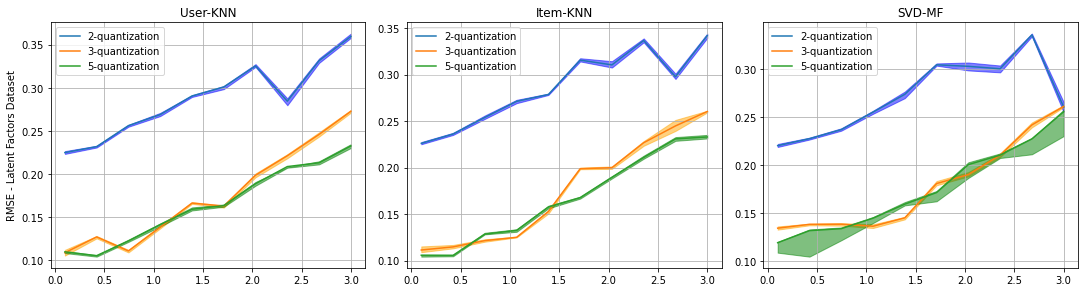

In [14]:
beta = np.linspace(0.1, 3, 10)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plt.tight_layout()
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[0].plot(beta, user_knn_result_avg['binary'], label='2-quantization')
axs[0].plot(beta, user_knn_result_avg['onetothree'], label='3-quantization')
axs[0].plot(beta, user_knn_result_avg['onetofive'], label='5-quantization')
axs[0].fill_between(beta, user_knn_result_1q['binary'],
                    user_knn_result_3q['binary'], color='blue', alpha=0.5)
axs[0].fill_between(beta, user_knn_result_1q['onetothree'],
                    user_knn_result_3q['onetothree'], color='orange', alpha=0.5)
axs[0].fill_between(beta, user_knn_result_1q['onetofive'],
                    user_knn_result_3q['onetofive'], color='green', alpha=0.5)
axs[0].set(ylabel='RMSE - Latent Factors Dataset', title='User-KNN')
axs[0].legend(loc='upper left')

axs[1].plot(beta, item_knn_result_avg['binary'], label='2-quantization')
axs[1].plot(beta, item_knn_result_avg['onetothree'], label='3-quantization')
axs[1].plot(beta, item_knn_result_avg['onetofive'], label='5-quantization')
axs[1].fill_between(beta, item_knn_result_1q['binary'],
                    item_knn_result_3q['binary'], color='blue', alpha=0.5)
axs[1].fill_between(beta, item_knn_result_1q['onetothree'],
                    item_knn_result_3q['onetothree'], color='orange', alpha=0.5)
axs[1].fill_between(beta, item_knn_result_1q['onetofive'],
                    item_knn_result_3q['onetofive'], color='green', alpha=0.5)
axs[1].legend(loc='upper left')
axs[1].set(title='Item-KNN')
beta = np.linspace(0.1, 3, 10)
axs[2].plot(beta, svd_result_avg['binary'], label='2-quantization')
axs[2].plot(beta, svd_result_avg['onetothree'], label='3-quantization')
axs[2].plot(beta, svd_result_avg['onetofive'], label='5-quantization')
axs[2].fill_between(beta, svd_result_1q['binary'],
                    svd_result_3q['binary'], color='blue', alpha=0.5)
axs[2].fill_between(beta, svd_result_1q['onetothree'],
                    svd_result_3q['onetothree'], color='orange', alpha=0.5)
axs[2].fill_between(beta, user_knn_result_1q['onetofive'],
                   svd_result_3q['onetofive'], color='green', alpha=0.5)
axs[2].set(title='SVD-MF')
axs[2].legend(loc='upper left')

# axs[1][0].grid()
# axs[1][1].grid()
# axs[1][2].grid()
# axs[1][0].plot(beta, user_knn_result_avg['binary'], label='2-quantization')
# axs[1][0].plot(beta, user_knn_result_avg['onetothree'], label='3-quantization')
# axs[1][0].plot(beta, user_knn_result_avg['onetofive'], label='5-quantization')
# axs[1][0].set(xlabel='beta', ylabel='RMSE - ML100K Dataset')
# axs[1][0].legend(loc='upper left')

# axs[1][1].plot(beta, item_knn_result_avg['binary'], label='2-quantization')
# axs[1][1].plot(beta, item_knn_result_avg['onetothree'], label='3-quantization')
# axs[1][1].plot(beta, item_knn_result_avg['onetofive'], label='5-quantization')
# axs[1][1].set(xlabel='beta')
# axs[1][1].legend(loc='upper left')

# axs[1][2].plot(beta, svd_result_avg['binary'], label='2-quantization')
# axs[1][2].plot(beta, svd_result_avg['onetothree'], label='3-quantization')
# axs[1][2].plot(beta, svd_result_avg['onetofive'], label='5-quantization')
# axs[1][2].set(xlabel='beta')
# axs[1][2].legend(loc='upper left')
fig.show()
fig.savefig('./paper/figures/1.png', dpi=400, bbox_inches='tight')


# Stage 2 experiment

## ml-100k dataset

In [10]:
# beta = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8])
# p = [0] * 10
# results_better = [0] * 10
# results = [0] * 10

# for it in range(1):
#     truth = generate_ground_truth_matrix((1000, 1000), environment='ml-100k-v1')
#     users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
#         truth, quantization='onetofive', bias='full underlying', beta=3)
#     train_df = to_dataframe(ratings)    
#     for i in range(10):
#         p[i] = masked_nb_propensity_estimation(truth, ratings, P.shape, beta=beta[i])
#     reader = Reader(rating_scale=(0, 1))
#     data = Dataset.load_from_df(
#         train_df[['userID', 'itemID', 'rating']], reader)
#     trainset = data.build_full_trainset()
#     test_df = generate_test_dataframe(R_no_noise)
#     testset = Dataset.load_from_df(
#         test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
#     for i in range(10):
#         algo_better = PropensitySVD(p[i], n_epochs=20)
#         algo = SVD(n_epochs=20)
#         algo_better.fit(trainset)
#         algo.fit(trainset)
#         results_better[i] += accuracy.rmse(algo_better.test(testset))
#         results[i] += accuracy.rmse(algo.test(testset))
# results_better = np.array(results_better) / 10
# results = np.array(results) / 10

## Synthetic dataset

In [11]:
# beta = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8])
# p = [0] * 10
# results_better_synthetic = [0] * 10
# results_synthetic = [0] * 10

# for it in range(1):
#     truth = generate_ground_truth_matrix((500, 500), environment='latent-static-v1')
#     users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
#         truth, quantization='onetofive', bias='full underlying', beta=3)
#     train_df = to_dataframe(ratings)    
#     for i in range(10):
#         p[i] = masked_nb_propensity_estimation(truth, ratings, P.shape, beta[i])
#     reader = Reader(rating_scale=(0, 1))
#     data = Dataset.load_from_df(
#         train_df[['userID', 'itemID', 'rating']], reader)
#     trainset = data.build_full_trainset()
#     test_df = generate_test_dataframe(R_no_noise)
#     testset = Dataset.load_from_df(
#         test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
#     for i in range(10):
#         algo_better = PropensitySVD(p[i], n_epochs=20)
#         algo = SVD(n_epochs=20)
#         algo_better.fit(trainset)
#         algo.fit(trainset)
#         results_better_synthetic[i] += accuracy.rmse(algo_better.test(testset))
#         results_synthetic[i] += accuracy.rmse(algo.test(testset))
# results_better_synthetic = np.array(results_better) / 1   
# results_synthetic = np.array(results) / 1


In [12]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# axs[0].plot(beta, results, label='MF')
# axs[0].plot(beta, results_better, label='NBPE-MF')
# axs[0].legend()
# axs[0].set(xlabel='beta', ylabel='RMSE', title='ML100k Dataset')
# axs[1].plot(beta, results_synthetic, label='MF')
# axs[1].plot(beta, results_better_synthetic, label='NBPE-MF')
# axs[1].legend()
# axs[1].set(xlabel='beta', ylabel='RMSE', title='Latent Factors Dataset')
# fig.show()
# fig.savefig('images/2.png', dpi=300)